In [1]:
%env ALL_PROXY=http://127.0.0.1:33001
%env HTTP_PROXY=http://127.0.0.1:33001
%env HTTPS_PROXY=http://127.0.0.1:33001

env: ALL_PROXY=http://127.0.0.1:33001
env: HTTP_PROXY=http://127.0.0.1:33001
env: HTTPS_PROXY=http://127.0.0.1:33001


In [2]:
!curl google.com

<HTML><HEAD><meta http-equiv="content-type" content="text/html;charset=utf-8">
<TITLE>301 Moved</TITLE></HEAD><BODY>
<H1>301 Moved</H1>
The document has moved
<A HREF="http://www.google.com/">here</A>.
</BODY></HTML>


# Import

If change the model, in training step, you need to 
1. change the log chapter
2. change the model code
3. change the wandb chapter

In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.nn as nn
from sklearn.model_selection import KFold, train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
import wandb

In [4]:
import sys
sys.path.insert(0, "/root/Soil-Column-Procedures")

from API_functions.DL import load_data, log, seed
from API_functions import file_batch as fb

# Hyperparameter and log

In [5]:
my_parameters = {
    'seed': 409,

    'Kfold': None,
    'ratio': 0.2,

    'model': 'U-Net',
    'optimizer': 'adam',
    'learning_rate':  0.0001,
    'batch_size': 32,
    'loss_function': 'cross_entropy',

    'n_epochs': 1000,
    'patience': 50,
}

device = 'cuda'
mylogger = log.Logger('all')

seed.stablize_seed(my_parameters['seed'])

# Transform

In [6]:
# For training data
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    # A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

# For validation and test data
transform_val = A.Compose([
    ToTensorV2(),
])

# Model

In [7]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCELoss()

    def forward(self, inputs, targets, smooth=1):
        # First, calculate the BCE loss
        inputs = torch.sigmoid(inputs)
        bce_loss = self.bce(inputs, targets)
        
        # Calculate Dice Loss
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        
        # Combine BCE + Dice
        return 0.5 * bce_loss + 0.5 * dice_loss

In [8]:
# model = smp.PSPNet(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
# )
# model = model.to(device)

In [9]:
model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
model = model.to(device)

In [10]:
# model = smp.DeepLabV3Plus(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
# )
# model = model.to(device)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=my_parameters['learning_rate'])
criterion = DiceBCELoss()

# Train

The codes below are only for training.

In test step, you need to proceed the codes above and the test chapter code.

## Wandb

In [ ]:
wandb.init(
    project="U-Net",
    name='10.using U-Net',
    config=my_parameters,
)

## Load_data

In [ ]:
data_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/train_images/', None, 'png')
labels_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/train_labels/', None, 'png')


data = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in data_paths]
labels = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in labels_paths]
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=my_parameters['ratio'], random_state=my_parameters['seed'])


train_dataset = load_data.my_Dataset(train_data, train_labels, transform=transform_train)
val_dataset = load_data.my_Dataset(val_data, val_labels, transform=transform_val)


train_loader = DataLoader(train_dataset, batch_size=my_parameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=my_parameters['batch_size'], shuffle=False)


print(f'len of train_data: {len(train_data)}, len of val_data: {len(val_data)}')

## Train

In [ ]:
val_loss_best = 100000

for epoch in range(my_parameters['n_epochs']):
    model.train()
    train_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        if outputs.dim() == 4 and outputs.size(1) == 1:
            outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss_mean = train_loss / len(train_loader.dataset)


    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            if outputs.dim() == 4 and outputs.size(1) == 1:
                outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)

    val_loss_mean = val_loss / len(val_loader.dataset)
    dict = {'train_loss': train_loss_mean, 'epoch': epoch, 'val_loss': val_loss_mean}
    mylogger.log(dict)

    if val_loss_mean < val_loss_best:
        val_loss_best = val_loss_mean
        torch.save(model.state_dict(), f"model_{my_parameters['model']}.pth")
        print(f'Model saved at epoch {epoch}, val_loss: {val_loss_mean}')

In [ ]:
wandb.finish()

# Test

If changes the model
1. Test inference6, 7, 8 are for U-Net, DeeplabV3+, PSPNet. Remember to change the path.
2. Do change the 'model' chapter in train step.
3. Change the torch.load function

## Test model

In [13]:
def save_image(image, path):
    """Save a tensor as an image."""
    image = image.squeeze().cpu().numpy()
    plt.imsave(path, image, cmap='gray')

def test_model(model, test_loader, device='cuda'):
    # model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients to speed up this part
        loss = 0

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            outputs = torch.sigmoid(outputs)  # Apply sigmoid to get values between 0 and 1

            if outputs.dim() == 4 and outputs.size(1) == 1:
                outputs = outputs.squeeze(1)
            loss = loss + criterion(outputs, labels).item()
            outputs = outputs > 0.5  # Threshold the probabilities to create a binary mask
            
            # Save output images
            for idx, output in enumerate(outputs):
                save_path = f'/root/Soil-Column-Procedures/data/version0/inference/tests_inference6/002_ou_DongYing_{i*test_loader.batch_size + idx + 13635}_roi_selected.png'
                save_image(output, save_path)

            print(f'Processed batch {i+1}/{len(test_loader)}')
        
        loss_avg = loss / len(test_loader.dataset)
        print(f'Loss: {loss}')


In [14]:
# Test the model, using the model define before

# model.load_state_dict(torch.load('model_PSPNet.pth', weights_only=True))
# model.load_state_dict(torch.load('model_DeepLabv3+.pth', weights_only=True))
model.load_state_dict(torch.load('model_U-Net.pth', weights_only=True))

model = model.to(device)

## Test data loader

In [15]:
test_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/test_images/', None, 'png')
test_labels_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/test_labels/', None, 'png')
tests = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in test_paths]
test_labels = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in test_labels_paths]


test_dataset = load_data.my_Dataset(tests, test_labels, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=my_parameters['batch_size'], shuffle=False)


print(f'len of test_data: {len(tests)}')

5 images have been found in /root/Soil-Column-Procedures/data/version0/test_images/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/test_images/002_ou_DongYing_13635_roi_selected.png
/root/Soil-Column-Procedures/data/version0/test_images/002_ou_DongYing_13636_roi_selected.png
/root/Soil-Column-Procedures/data/version0/test_images/002_ou_DongYing_13637_roi_selected.png
Get names completely!
5 images have been found in /root/Soil-Column-Procedures/data/version0/test_labels/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/test_labels/002_ou_DongYing_13635_roi_selected.png
/root/Soil-Column-Procedures/data/version0/test_labels/002_ou_DongYing_13636_roi_selected.png
/root/Soil-Column-Procedures/data/version0/test_labels/002_ou_DongYing_13637_roi_selected.png
Get names completely!
len of test_data: 5


## Test

In [16]:
test_model(model, test_loader)

/root/Soil-Column-Procedures/API_functions/DL/load_data.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)
/root/Soil-Column-Procedures/API_functions/DL/load_data.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label/255, dtype=torch.float32)


Processed batch 1/1
Loss: 0.8385220170021057


# Visualize

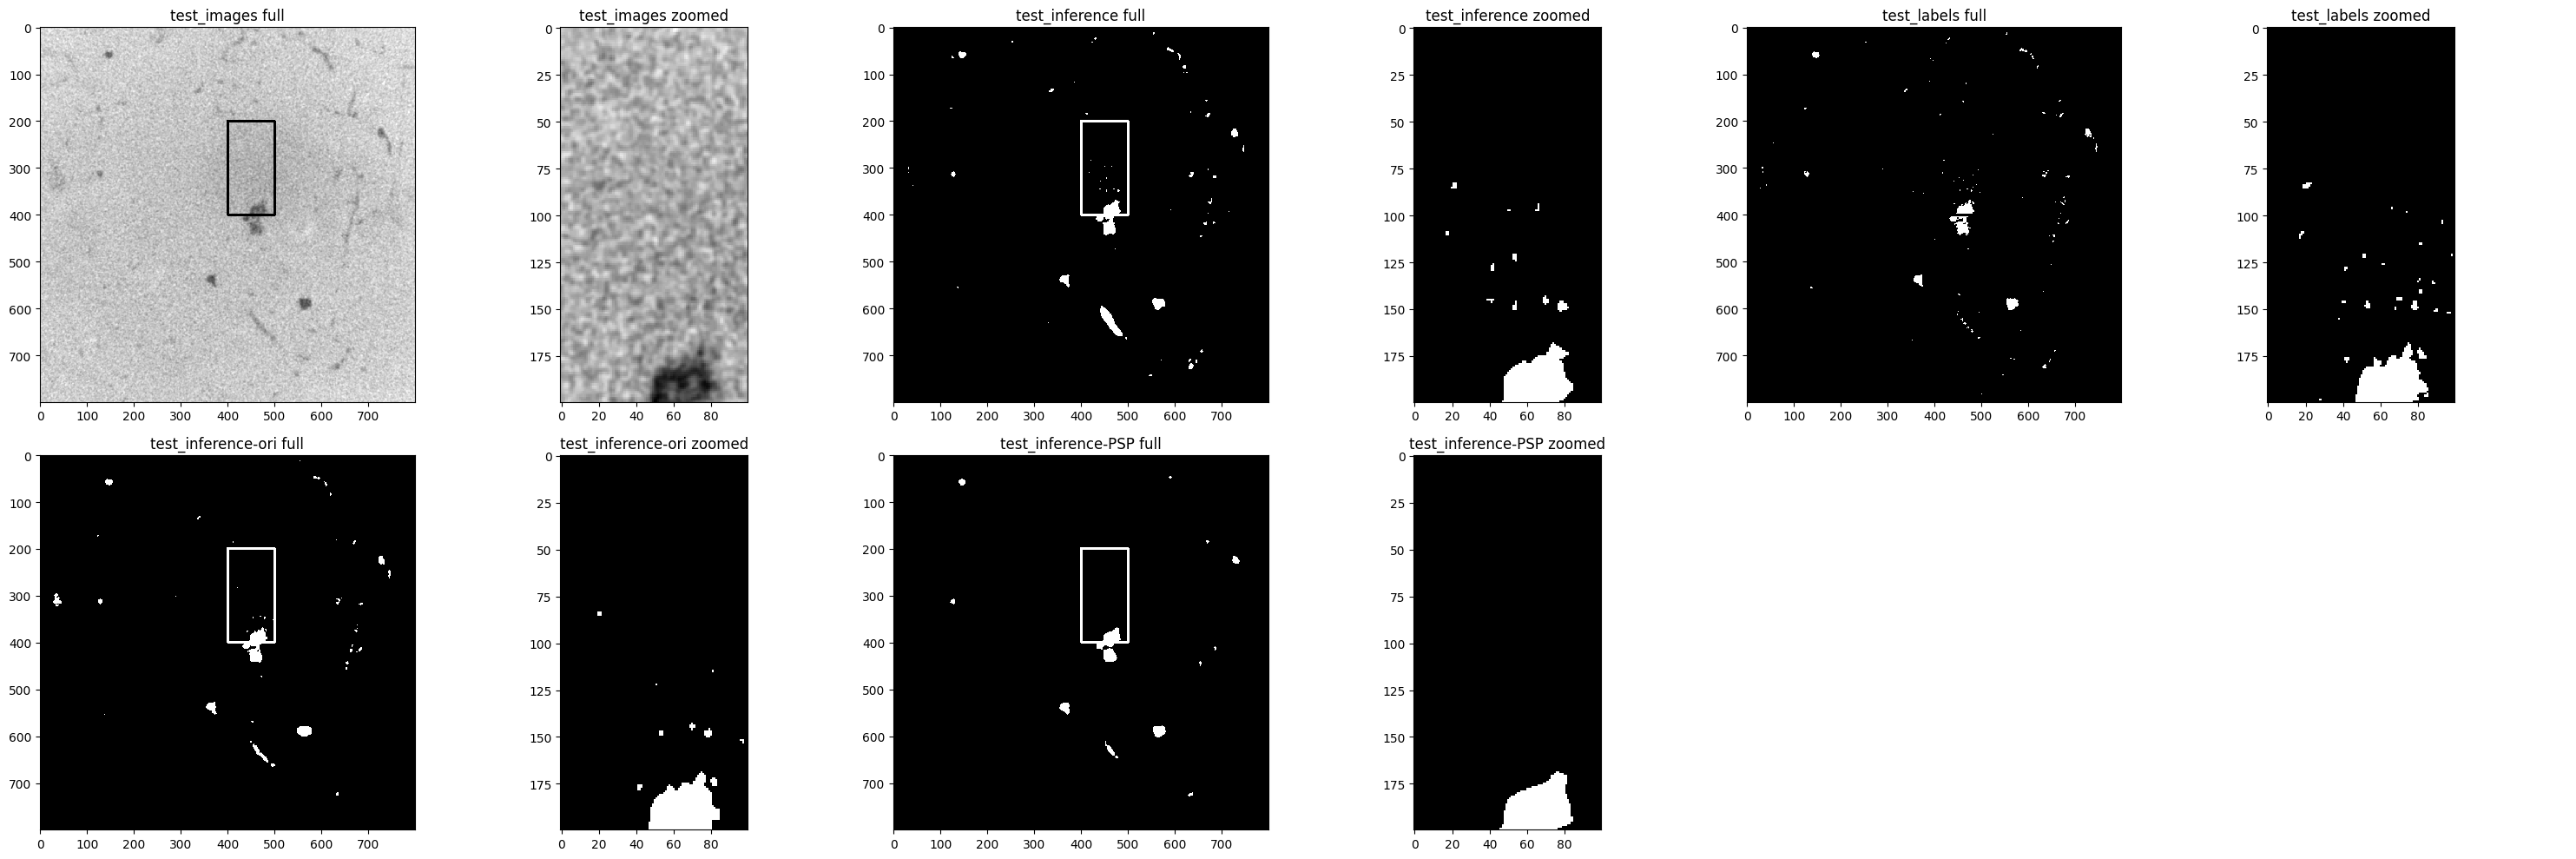

In [17]:
from API_functions.Visual import file_compare as fc
# %matplotlib qt

db = fc.ImageDatabase()
# image_processor.add_result('pre_processed', tpi.user_threshold(image_processor.image, 160))
zoom = fc.ZoomRegion(200, 400, 100, 200)
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/test_images/', 'test_images')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/test_labels/', 'test_labels')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/inference/tests_inference7/', 'test_inference')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/inference/tests_inference6/', 'test_inference-ori')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/inference/tests_inference8/', 'test_inference-PSP')
image_processor = db.get_image_processor('002_ou_DongYing_13636_roi_selected.png')
image_processor.show_images('test_images', 'test_inference', 'test_labels', "test_inference-ori", "test_inference-PSP", zoom_region=zoom)